In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from copy import deepcopy
from preprocessing import Preprocess
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt
import scipy.io

from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import *

In [2]:
#Rule Object structure
class rule_object():
    def __init__(self,complete_rules,prem_terms,rules,wd_,index):
        self.complete_rules = complete_rules
        self.prem_terms = prem_terms
        self.rules = rules
        self.index = index
        self.wd_ = wd_

In [3]:
old_data = pd.read_csv('AirQualityUCI.csv',sep=';',decimal='.')

old_data.dropna(thresh=1, inplace=True)
old_data.drop(labels=['Unnamed: 15', 'Unnamed: 16'],axis=1,inplace=True)

old_data.fillna(method='bfill',inplace=True)

def convert_object_to_float(data,datanames):
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

inames = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']

data = convert_object_to_float(old_data,inames)

numeric_data = data.select_dtypes(include=['float'])
   
ndata = numeric_data.where(numeric_data != -200)

ndata.isnull().sum()



CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [4]:
ndata.fillna(method='bfill',inplace=True)

In [5]:
ndata.isnull().sum()

CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)         8126
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

In [6]:
ndata.drop(labels=['NMHC(GT)'], axis=1, inplace=True)

In [7]:
ndata.drop(labels=['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)'],axis=1,inplace=True)

In [8]:
dataframe = ndata[9000:-24]

dataframe = dataframe[['NO2(GT)', 'C6H6(GT)', 'NOx(GT)', 'T', 'CO(GT)']]

dataset = dataframe.values

dataframe

,NO2(GT),C6H6(GT),NOx(GT),T,CO(GT)
9000,128.0,6.6,240.0,19.3,1.7
9001,155.0,12.7,398.0,17.3,2.9
9002,176.0,14.8,585.0,16.0,4.0
9003,179.0,12.3,590.0,15.6,4.0
9004,124.0,6.3,295.0,14.8,1.9
...,...,...,...,...,...
9328,113.0,3.4,166.0,21.1,1.4
9329,115.0,5.3,171.0,24.0,1.3
9330,124.0,5.3,177.0,26.5,1.4
9331,86.0,3.8,119.0,28.7,1.0


In [9]:
lag = 24
h_test = 24
h_val = 24
#h_train = dataset.shape[0] - h_val - h_test - lag - 2
h_train = dataset.shape[0] - h_test - h_val

a = dataset.shape[0]
all_data = dataset[lag:,:]
training_data = dataset[lag:lag+h_train,:]
test_data = dataset[a - h_test:a,:]

In [10]:
ndata

,CO(GT),C6H6(GT),NOx(GT),NO2(GT),T,RH,AH
0,2.6,11.9,166.0,113.0,13.6,48.9,0.7578
1,2.0,9.4,103.0,92.0,13.3,47.7,0.7255
2,2.2,9.0,131.0,114.0,11.9,54.0,0.7502
3,2.2,9.2,172.0,122.0,11.0,60.0,0.7867
4,1.6,6.5,131.0,116.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...
9352,3.1,13.5,472.0,190.0,21.9,29.3,0.7568
9353,2.4,11.4,353.0,179.0,24.3,23.7,0.7119
9354,2.4,12.4,293.0,175.0,26.9,18.3,0.6406
9355,2.1,9.5,235.0,156.0,28.3,13.5,0.5139


In [11]:
all_data.shape

(309, 5)

In [12]:
test_data.shape

(24, 5)

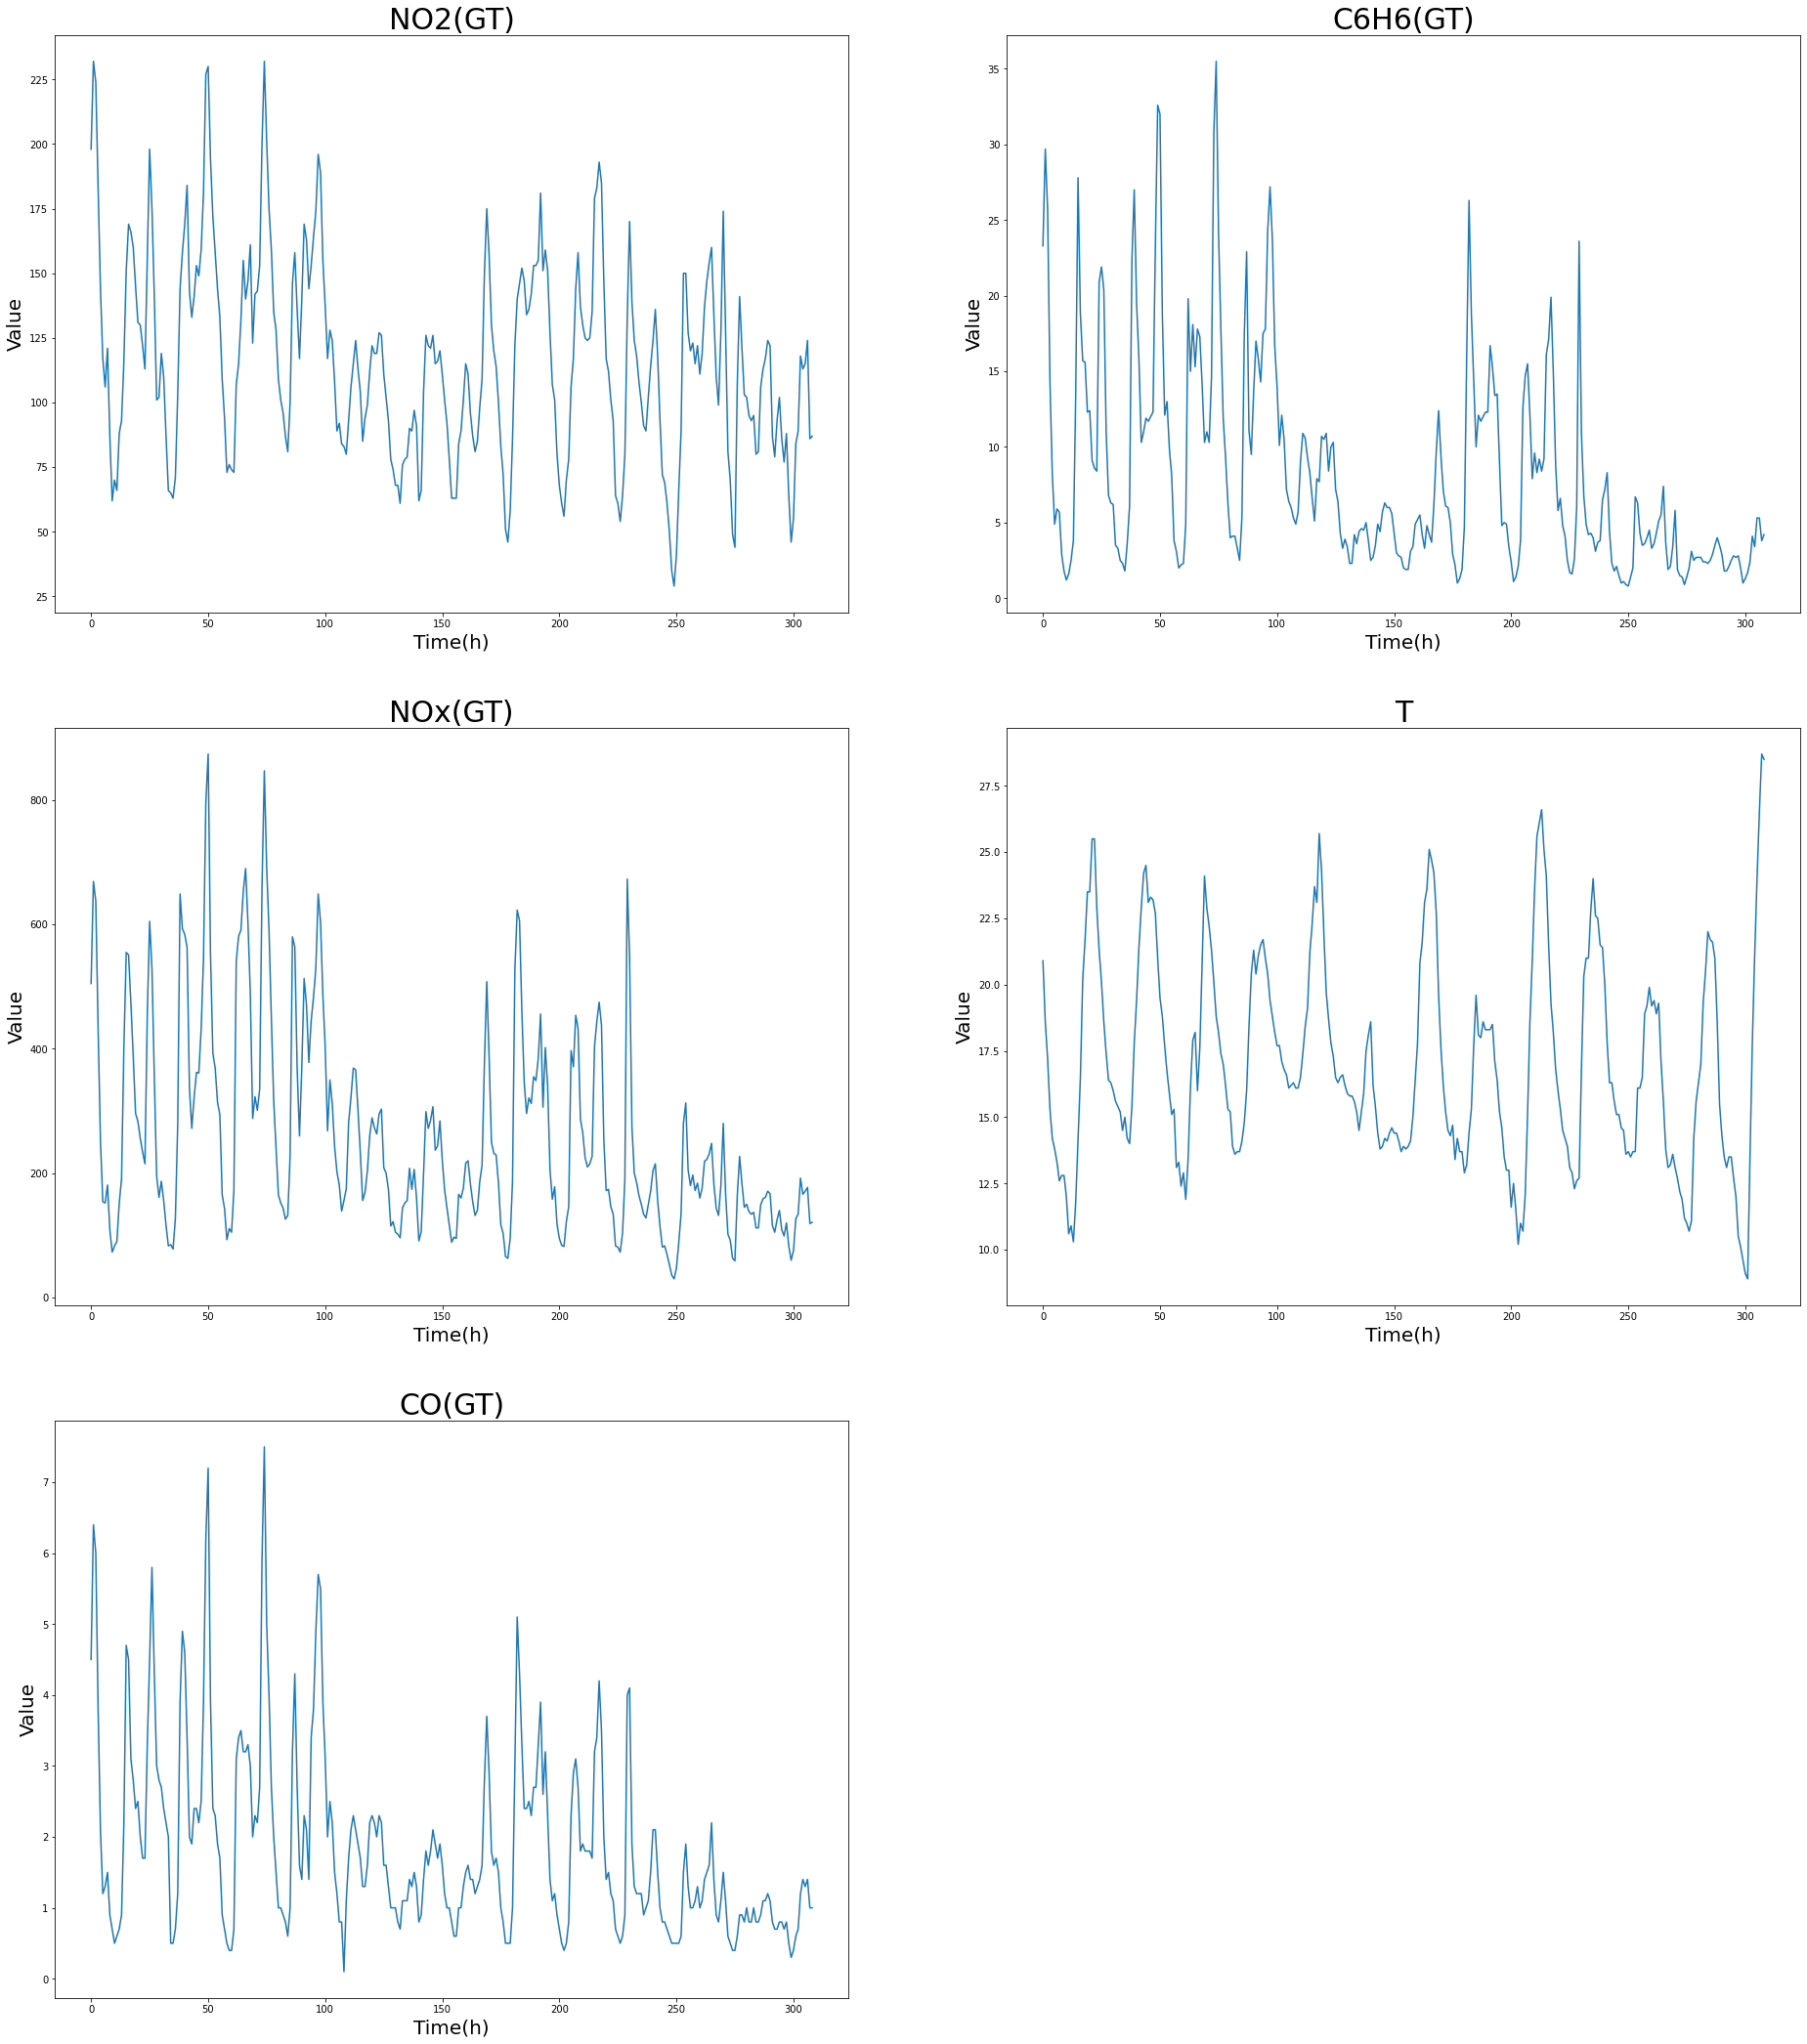

In [13]:
plt.figure(figsize=(32,50))
for n in range(dataframe.shape[1]):
    plt.subplot(4,2,n+1)
    plt.plot(all_data[:,n])
    plt.xlabel('Time(h)',fontsize=20)
    plt.ylabel('Value',fontsize=20)
    plt.title(dataframe.columns[n],fontsize=30)

In [14]:
for n in range(dataframe.shape[1]):
    print(f'{dataframe.columns[n]}: Max Value: {dataframe[dataframe.columns[n]].max()}')
    print(f'{dataframe.columns[n]}: Min Value: {dataframe[dataframe.columns[n]].min()}')

NO2(GT): Max Value: 232.0
NO2(GT): Min Value: 29.0
C6H6(GT): Max Value: 35.5
C6H6(GT): Min Value: 0.8
NOx(GT): Max Value: 874.0
NOx(GT): Min Value: 30.0
T: Max Value: 28.7
T: Min Value: 8.9
CO(GT): Max Value: 7.5
CO(GT): Min Value: 0.1


In [15]:
#data = data1[:,[0, 61, 147, 241]]
#data_ = training_values[:,[0,6]]
#data_ = training_values[:,[0,2,6,7]]
data_ = training_data
#data_ = training_values[:,[0, 61, 147, 241]]

In [16]:
data_.shape

(285, 5)

In [17]:
#Basic informations 
num_predictors = 60
num_input = 12
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False

#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

num_series = data_.shape[1]  #Numero de series do problema, extraído dos dados

max_rulesize = 5 #Max numbers of premises rules.
min_activation = 0.58 #Minimum activation

form_method = 'nmean'
split_method = 'FCD'
solve_method = 'mqr'
#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
num_groups = 7

defuzz_method = 'height'

ensemble_rules = None

total_number = data_.shape[1]*lag


filepath = 'results V1'



C:\Users\Diego\AppData\Local\Temp\ipykernel_13628\856743049.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lag_notused = np.array([[4,5],[4,5],[4],[4,5]])


In [18]:
#Normalize data 
# scaler = StandardScaler()
#scaler = MinMaxScaler()
preprocess_data = Preprocess(data_, lag, h_prev=h_val,num_series=num_series, target_position = 1)

#For training set
#training_set_orig, val_set_orig = preprocess_data.diff_series()
training_set, val_set = preprocess_data.split_data()
correlation_array = preprocess_data.spearman_corr_weights()
autocorrelation_matrix = preprocess_data.linear_acf_weights()
#training_set_orig, val_set_orig, trends = preprocess_data.detrend_series()

#diff_data = np.concatenate((training_set_orig, val_set_orig))

#norm_data = scaler.fit_transform(diff_data)
#training_set = scaler.transform(training_set_orig)
#val_set = scaler.transform(val_set_orig)

#training_set[abs(training_set) > 3] = 0
''' 
yp - dados de entrada do modelo com defasagem de 24 passos [t + lag: t + (dataset[0] - lag), numero de variáveis], 
yt - dados de entrada do modelo com defasagem de 25 passos (1 passo a frente de yt) [t + (lag +1), t + (dataset[0] - lag) + 1, numero de variáveis],
yp_lagged - amtriz oformada pela defasagem de todas as variáveis juntas[t + lag: t + (dataset[0] - lag), numero de variáveis*lag]'''
yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)
#For all set. This will be useful for initial values of prediction
all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = dataset, lag = lag)

In [19]:
yt_var_samples, yp_var_samples, yp_lagged_var_samples = preprocess_data.generate_subsamples(correlation_array, 
                                                                                            autocorrelation_matrix, 
                                                                                            num_input,
                                                                                            training_set)

In [20]:
columns_to_keep = np.random.choice(training_set.shape[1], np.random.randint(1, training_set.shape[1]+1), p=correlation_array, replace=False)
yp_var_samples = deepcopy(yp)
yt_var_samples = deepcopy(yt)
yp_var_samples[:, [i for i in range(num_series) if i not in columns_to_keep]] = np.nan
yt_var_samples[:, [i for i in range(num_series) if i not in columns_to_keep]] = np.nan

yp_lagged_var_samples = deepcopy(yp_lagged)
# window_var_samples = np.split(np.arange(0, lag*num_series), num_series)
# for _var in range(num_series):
#     if _var not in columns_to_keep:
#         yp_lagged_var_samples[:, window_var_samples[_var]] = np.nan

In [21]:
import seaborn as sns
from copy import deepcopy
from utils import *

import itertools
import json
import os

#For e-autoMFIS, we import all of them.
from autoMFIS_test import autoMFIS
import numpy as np
import scipy.io
from reweight import Reweight
from fuzzyfication import Fuzzification
from defuzzification import Defuzzification
import matplotlib.pyplot as plt
from predict import predict, predict_pattern

def convert_object_to_float(data,datanames):
    
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

##Assertion for ensemble rules
#Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

#This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
def correct_bug(ensemble_rules,max_rulesize=0):
    correct_rule = []
    d_stacked_rules = []
    new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


    for  n_times in range(ensemble_rules.shape[1]):
        t_rules = ensemble_rules[:,n_times]
        correct_rule = []
        d_stacked_rules = []
        k = 0
        for rule in t_rules:
            #print(rule)
            #print(len(rule))
            #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
            if len(rule) > max_rulesize + 1:
                #print(rule)
                for i in rule:
                    #k += 1
                    if isinstance(i,tuple):
                        #print(i)
                        correct_rule.append(i)
                    else:
                        if len(correct_rule) == 0:
                            #print(i)
                            pass
                            #d_stacked_rules.append(i)
                        else:
                            #print(correct_rule)
                            new_ensemble_rules[k,n_times] = correct_rule
                            k += 1
                            #d_stacked_rules.append(correct_rule)
                            correct_rule = []
                            #d_stacked_rules.append(i)
            else:
                new_ensemble_rules[k,n_times] = rule
                k += 1
                #d_stacked_rules.append(rule)
            
        #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

    return new_ensemble_rules

def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
    t_rules = deepcopy(new_ensemble_rules[:,0])
    no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
    no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
    no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
    new_t_rules = None

    k = 0
    j = 0
    for rule in t_rules:
        if new_t_rules is None:
            new_t_rules = [rule]
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1

        elif not check_duplicate_rules(rule,new_t_rules):
            new_t_rules.append(rule)
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1
        j += 1

    new_rules = deepcopy(no_duplicated_ensemble[:k,:])
    new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
    new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

    return new_rules, new_prem_terms, new_antecedents



In [22]:
#t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]
#t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
#yp = deepcopy(yp[t_lagged,:])
#yt = deepcopy(yt[t_lagged,:])
#yp_lagged = deepcopy(yp_lagged[t_lagged,:])

#data = deepcopy(data[t[len(t)-len(t_lagged):],:])
#in_sample = data[:data.shape[0]-h_prev,:]
#out_sample = data[data.shape[0]-h_prev:,:]

#print(len(t_lagged))

In [23]:
###############Fuzzificacao

Fuzzyfy = Fuzzification(fuzzy_method)

#Lembrete: 
#axis 0 - Registros da série
#axis 1 - Valor de pertinência ao conjunto Fuzzy
#axis 2 - Numero de séries

first_time = True
for n in range(num_series):
    _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
    mX, _ = Fuzzyfy.fuzzify(yp_var_samples[:,n],mf_params,num_groups=num_groups)
    mY, _ = Fuzzyfy.fuzzify(yt_var_samples[:,n],mf_params,num_groups=num_groups)
    if first_time:
# Matriz tridimensional (Entradas, nº de partições, nº de variáveis) com as entradas convertidas para valores de pertinência para todas as variáveis
        mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
#Semelhante a variável MX_
        mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
# Matriz com os valores das partições de cada variável 
        mf_params_ = np.ndarray([mf_params.shape[0],num_series])
        first_time = False
#Mapeamento dos valores
    mX_[:,:,n] = mX
    mY_[:,:,n] = mY
    mf_params_[:,n] = mf_params.ravel()
    #print(mf_params)
    #print(mX.shape)


mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
for i in range(num_series):
    mf_params = mf_params_[:,i]
    for j in range(lag):
        mX, _ = Fuzzyfy.fuzzify(yp_lagged_var_samples[:,i*lag+j],mf_params,num_groups=num_groups)
        mX_lagged_[:,:,i*lag+j] = mX
        #print(i*lag+j)

############## Formulacao
if not_used_lag:
    new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
else:
    new_mX = mX_lagged_



In [24]:
# ###############Fuzzificacao

# Fuzzyfy = Fuzzification(fuzzy_method)

# #Lembrete: 
# #axis 0 - Registros da série
# #axis 1 - Valor de pertinência ao conjunto Fuzzy
# #axis 2 - Numero de séries

# first_time = True
# for n in range(num_series):
    
    
#     _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
#     mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
#     mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
#     if first_time:
# # Matriz tridimensional (Entradas, nº de partições, nº de variáveis) com as entradas convertidas para valores de pertinência para todas as variáveis
#         mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
# #Semelhante a variável MX_
#         mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
# # Matriz com os valores das partições de cada variável 
#         mf_params_ = np.ndarray([mf_params.shape[0],num_series])
#         first_time = False
# #Mapeamento dos valores
#     mX_[:,:,n] = mX
#     mY_[:,:,n] = mY
#     mf_params_[:,n] = mf_params.ravel()
#     #print(mf_params)
#     #print(mX.shape)


# mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
# for i in range(num_series):
#     mf_params = mf_params_[:,i]
#     for j in range(lag):
#         mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
#         mX_lagged_[:,:,i*lag+j] = mX
#         #print(i*lag+j)


# #mX_lagged_[:,:,not_select_subsample] = 0

# #print(mX_lagged_[:,:,not_select_subsample])
# ############## Formulacao
# if not_used_lag:
#     new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
# else:
#     new_mX = mX_lagged_



In [ ]:
'''
min_error - variável a ser subsituída pelos melhores resultads obtidos  na etapa de validação
bres - melhor resultado obtido ao final da execução de todos o comitê de previsores
initial_values - Não entendi pq pega a esta linha em específico para o predict(?)
in_sample - dados de treinamento
out_sample - dados de teste (a confirmr)
num_predictors - total de previsores (regras formadas) no ensemble
'''
min_error = 400.0

bres = min_error

initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)
in_sample = deepcopy(training_set)
out_sample = deepcopy(val_set)




print('='*89)

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')

print('='*89)


#num_predictors = 1

#Concatenate rules
for i in range(num_predictors):
    #try:
    model = autoMFIS(diff_series=diff_series,
                     detrend_series=detrend_series,
                     fuzzy_method=fuzzy_method,
                     solve_method=solve_method,
                     defuzz_method=defuzz_method, 
                     num_groups = num_groups, 
                     h_prev = out_sample.shape[0],
                     num_series = num_series, 
                     max_rulesize = max_rulesize,
                     min_activation = min_activation, 
                     lag = lag, 
                     hide_values = False, 
                     form_method = form_method, 
                     split_method = split_method, 
                     show=True)

    
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    t_mX_lagged = deepcopy(mX_lagged_)
    t_mX_lagged[:,:,not_select_subsample] = 0

    model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, t_mX_lagged)        

    complete_rules, prem_terms, rules, agg_training, wd_ = model.train(dataset,
                                                                       yt=yt,
                                                                       yp=yp,
                                                                       yp_lagged=yp_lagged,
                                                                       in_sample=in_sample,
                                                                       out_sample=out_sample,
                                                                       not_select_subsample=not_select_subsample,
                                                                       lag_notused=[], 
                                                                       debug=True)

    #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
    print(f'Predict on validation set - #{i}')
    #Prediction of a single subset
    #yt_totest, errors = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
    predicted_values = np.zeros(test_data.shape)
    yt_totest, errors = model.predict(initial_values, 
                                      data=dataset, 
                                      in_sample = yt, 
                                      out_sample=val_set, 
                                      agg_training=agg_training,
                                      h_prev=h_test,
                                      n_attempt=f'p_subsample_{i}',
                                      wd_=wd_,
                                      ensemble_antecedents=rules,
                                      ensemble_rules=complete_rules,
                                      filepath=filepath,
                                      lim=min_error, 
                                      fig_axis=[4,2],
                                      ndata=dataframe.columns,
                                      show=False,
                                      plot_image = True)
    #real_yt = scaler.inverse_transform(yt_totest)
    real_yt = deepcopy(yt_totest)
    #errors = smape(real_yt,test_data)
    #res = np.mean(2*abs(test_data-real_yt) / (abs(real_yt) + abs(test_data)))
    print(errors)
    res = errors[1,4]
    print(res)
    if res < bres:
        bres = res 
        y_best = yt_totest 
        best_complete_rules = complete_rules 
        best_prem_terms =  prem_terms
        best_rules = rules
        best_agg_training = agg_training 
        best_wd_ = wd_ 
        best_t_mx_lagged = t_mX_lagged

    #print(complete_rules)
    if errors[1,4] < 0.5:
        if ensemble_rules is None:
            ensemble_rules = complete_rules
            ensemble_prem_terms = prem_terms
            ensemble_antecedents = rules
            print(ensemble_rules.shape)
        else:
            ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
            
            ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
            ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
            print(ensemble_rules.shape)
            #print(ensemble_prem_terms.shape)
        #print(ensemble_rules[:,0])
    elif ensemble_rules is None and i == num_predictors - 1:
        ensemble_rules = complete_rules
        ensemble_prem_terms = prem_terms
        ensemble_antecedents = rules
        print('No rules match criteria. Using rules to fill the gap')
    #print('RMSE Errors = {}'.format(errors[0,:]))
    #print('RRSE Errors = {}'.format(errors[1,:]))
    #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
    
    '''
    print(errors)
    if errors[1,0] < min_error:
        ensemble_rules = deepcopy(complete_rules)
        ensemble_prem_terms = deepcopy(prem_terms)
        ensemble_antecedents = deepcopy(rules)
        wd__ = wd_
        min_error = errors[1,0]
    '''
    #except Exception as e:
        #print(e)
        #pass
print(res)  

Shape of in-sample is 261
Shape of lagged data is 236
Shape of validation set is 24
Step 1 - Fuzzification


In [25]:
best_complete_rules.shape

(9, 5)

In [26]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, best_t_mx_lagged)

In [27]:
best_yt_totest, best_errors = model.predict(initial_values, 
                                      data=dataset, 
                                      out_sample=test_data, 
                                      agg_training=best_agg_training,
                                      h_prev=h_test,
                                      n_attempt='best_model',
                                      wd_=best_wd_ ,
                                      ensemble_antecedents=best_rules,
                                      ensemble_rules=best_complete_rules,
                                      filepath=filepath,
                                      lim=min_error, 
                                      fig_axis=[4,2],
                                      ndata=dataframe.columns,
                                      show=False,
                                      plot_image = True)

In [28]:
best_errors

array([[ 96.37599978,   3.13348847, 135.83936592,   8.52550269,
          0.93430009],
       [ 94.        ,   2.92916667, 131.58333333,   7.29216226,
          0.8875    ],
       [  1.        ,   1.        ,   1.        ,   0.5889586 ,
          1.        ]])

In [29]:

out_sample=test_data

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        best_yt_totest[:,i] = pd.DataFrame(best_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(best_yt_totest,1,axis=0)
    y_pp[0,:] = data[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = data[in_sample.shape[0],:]
    Y__ = best_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = best_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = best_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V1/best_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(f'{dataframe.columns[i]}',fontsize=32)
    plt.plot(best_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'], fontsize=26)
    plt.xlabel('Tempo(h)',fontsize=26)
    plt.ylabel('Valor',fontsize=26)
    k += 1


plt.savefig('results V1/best_model.png')    #plt.show()
plt.close()

In [30]:
ensemble_rules.shape

(9, 5)

In [31]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
ensemble_wd_, ensemble_agg_training = model.reweight_mf(mY_,ensemble_rules,ensemble_prem_terms)

C:\Users\Diego\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Diego\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
ensemble_yt_totest, ensemble_errors = model.predict(initial_values, 
                                      data=dataset, 
                                      out_sample=test_data, 
                                      agg_training=ensemble_agg_training,
                                      h_prev=h_test,
                                      n_attempt='ensemble_model',
                                      wd_=ensemble_wd_ ,
                                      ensemble_antecedents=ensemble_antecedents,
                                      ensemble_rules=ensemble_rules,
                                      filepath=filepath,
                                      lim=min_error, 
                                      fig_axis=[4,2],
                                      ndata=dataframe.columns,
                                      show=False,
                                      plot_image = True)

In [33]:
ensemble_errors

array([[ 96.37599978,   3.13348847, 135.83936592,   7.72636797,
          0.93430009],
       [ 94.        ,   2.92916667, 131.58333333,   6.5017228 ,
          0.8875    ],
       [  1.        ,   1.        ,   1.        ,   0.4983577 ,
          1.        ]])

In [34]:

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        ensemble_yt_totest[:,i] = pd.DataFrame(ensemble_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(ensemble_yt_totest,1,axis=0)
    y_pp[0,:] = data[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = data[in_sample.shape[0],:]
    Y__ = ensemble_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = ensemble_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = ensemble_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V1/ensemble_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(f'{dataframe.columns[i]}',fontsize=20)
    plt.plot(ensemble_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'])
    plt.xlabel('Tempo(h)',fontsize=15)
    plt.ylabel('Valor',fontsize=15)
    k += 1


plt.savefig('results V1/ensemble_model.png')    #plt.show()
plt.close()

In [35]:
cnt = 0
list_remove = []

dict_val = {}

for i in range(ensemble_prem_terms.shape[0]):
    except_one = np.copy(ensemble_prem_terms)
    v = except_one[i,:]
    idx = np.argwhere(v > 0.5).ravel()
    v = v[idx]
    rest = np.delete(except_one, i, axis=0)
    rest = rest[:,idx]
    cpare = np.tile(v,(rest.shape[0],1))
    m = np.minimum(rest,cpare) 
    M = np.maximum(rest,cpare) + 10e-15
    res = m/M
    mean = np.mean(res,axis=1)
    #plt.figure()
    #plt.hist(mean)
    
    vv = np.argwhere(mean > 0.6).ravel()

    if vv.shape[0] > 0:    
        vv[vv > i] += 1
        vv2 = np.append(vv,np.array([i]))

        eval_v = ensemble_prem_terms[vv2][:,idx]

        t = np.mean(eval_v,axis=1)

        keep_val = vv2[np.argmax(t)]
        vmax = np.max(t)
        print(f'{keep_val} : {vmax}')
        if keep_val not in list_remove:
            dict_val[keep_val] = 1
            list_remove.append(keep_val)
        else:
            dict_val[keep_val] = dict_val[keep_val] + 1

        cnt += np.argwhere(mean > 0.6).shape[0]


0 : 0.8695875281008697
1 : 0.8437629384278688
2 : 0.9540425531914891
3 : 0.9540425531914891
4 : 0.8701278294125849
5 : 0.8017813029688454
6 : 0.8017813029688454
7 : 0.8446202739007926
2 : 0.9948936170212764


In [36]:
filtered_rules = deepcopy(ensemble_rules[list_remove,:])
filtered_prems = deepcopy(ensemble_prem_terms[list_remove,:])
filtered_antecedents = deepcopy(ensemble_antecedents[list_remove,:])

In [37]:
filtered_rules.shape

(8, 5)

In [38]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
filtered_wd_, filtered_agg_training = model.reweight_mf(mY_,filtered_rules,filtered_prems)

C:\Users\Diego\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Diego\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
filtered_yt_totest, filtered_errors = model.predict(initial_values, 
                                 data=dataset, 
                                 out_sample=test_data, 
                                 agg_training=filtered_agg_training,
                                 h_prev=h_test,
                                 n_attempt='filtered_model',
                                 wd_=filtered_wd_,
                                 ensemble_antecedents=filtered_antecedents,
                                 ensemble_rules=filtered_rules, 
                                 filepath=filepath, lim=min_error,
                                 fig_axis=[4,2],
                                 ndata=dataframe.columns,
                                 show=False,
                                 plot_image = True)

In [40]:
filtered_errors

array([[ 96.37599978,   3.13348847, 135.83936592,   7.71598573,
          0.93430009],
       [ 94.        ,   2.92916667, 131.58333333,   6.51491424,
          0.8875    ],
       [  1.        ,   1.        ,   1.        ,   0.4976145 ,
          1.        ]])

In [41]:

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        filtered_yt_totest[:,i] = pd.DataFrame(filtered_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(filtered_yt_totest,1,axis=0)
    y_pp[0,:] = data[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = data[in_sample.shape[0],:]
    Y__ = filtered_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = filtered_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = filtered_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V1/filtered_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(f'{dataframe.columns[i]}',fontsize=20)
    plt.plot(filtered_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'])
    plt.xlabel('Tempo(h)',fontsize=15)
    plt.ylabel('Valor',fontsize=15)
    k += 1


plt.savefig('results V1/filtered_model.png')    #plt.show()
plt.close()

In [42]:
# import seaborn as sns 

# frame = pd.concat([
#         pd.DataFrame({'tempo(h)': range(len(out_sample)), 'NO2(GT)': test_data[:,0], 'type': 'real'}),
#         pd.DataFrame({'tempo(h)': range(len(out_sample)), 'NO2(GT)': filtered_yt_totest[:,0], 'type': 'previsto'})
#     ])
    
# #     frame['temp'] = [(x * (train_max['NO2(GT)'] - train_min['NO2(GT)'])) + train_min['NO2(GT)'] for x in frame['NO2(GT)']]
    
# sns.lineplot(x='tempo(h)', y='NO2(GT)', data=frame, hue='type')
        
# plt.tight_layout()
# plt.savefig('results/final_filtered.png')
# plt.show()